<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/1D_CNN_asof_011FEB1113.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install alpaca_trade_api

     |████████████████████████████████| 45 kB 2.9 MB/s 
     |████████████████████████████████| 1.3 MB 28.6 MB/s 
     |████████████████████████████████| 273 kB 53.6 MB/s 
     |████████████████████████████████| 103 kB 53.9 MB/s 
     |████████████████████████████████| 636 kB 20.5 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 271 kB 47.2 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [3]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

In [4]:
random_seed = 182
torch.manual_seed(random_seed)

In [5]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [6]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [7]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

from datetime import date

train_start = date(2017, 1, 1)
train_end = date(2019, 10, 31)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 730
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "WMT" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 0 # Number of days to off set the training data
train_raw, val_raw, test_raw, full_raw, offset_raw, complete_raw, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
    Time Frame: 0930-1930
    Backfilling NaNs
    Adjusting Volume to Zero if no Trading data is present
      - Assumption is that there were no trades duing that time 

  We will build over lapping arrays by 30 min to give ourselfs more
  oppurtunities to predict during a given trading day 
  """
  
  df = df.between_time('07:29','17:29') # intial sorting of data

  TZ = 'US/Eastern' # define the correct timezone

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  # build blank index that has ever 5 min interval represented
  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time').set_index("Time").between_time('09:29','17:29')

  # create the close array by back filling NA, to represent no change in close
  closeset_list = []
  prev_c = None

  for c in filtered_df["Close"]:

    if prev_c == None:
      if math.isnan(c):
        prev_c = 0
        closeset_list.append(0)
      else:
        prev_c = c
        closeset_list.append(c)
    
    elif prev_c != None:
      if c == prev_c:
        closeset_list.append(c)
      elif math.isnan(c):
        closeset_list.append(prev_c)
      else:
        closeset_list.append(c)
        prev_c = c
    
  filtered_df["Close"] = closeset_list

  # create the volume
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v

  filtered_df["Volume"] = volumeset_list
  
  adjvolumeset_list = []
  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df  

Number of days of Training Data 1033
Number of days of Validation Data 730
Number of days of Holdout Test Data 104


In [12]:
train_raw[275:300]

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2017-01-05 14:55:00-05:00,2017-01-05 14:55:00-05:00,69.155,69.19,69.1300,69.135,47281,69.162417
2017-01-05 15:00:00-05:00,2017-01-05 15:00:00-05:00,69.135,69.17,69.1347,69.150,56174,69.154908
2017-01-05 15:05:00-05:00,2017-01-05 15:05:00-05:00,69.150,69.19,69.1500,69.180,59639,69.172701
2017-01-05 15:10:00-05:00,2017-01-05 15:10:00-05:00,69.180,69.21,69.1800,69.205,33695,69.198801
2017-01-05 15:15:00-05:00,2017-01-05 15:15:00-05:00,69.205,69.25,69.2000,69.220,67612,69.229651
2017-01-05 15:20:00-05:00,2017-01-05 15:20:00-05:00,69.220,69.24,69.2000,69.235,54316,69.217230
2017-01-05 15:25:00-05:00,2017-01-05 15:25:00-05:00,69.240,69.28,69.2300,69.280,97848,69.249674
2017-01-05 15:30:00-05:00,2017-01-05 15:30:00-05:00,69.280,69.30,69.2700,69.290,56744,69.282175
2017-01-05 15:35:00-05:00,2017-01-05 15:35:00-05:00,69.300,69.32,69.2900,69.300,94928,69.302853


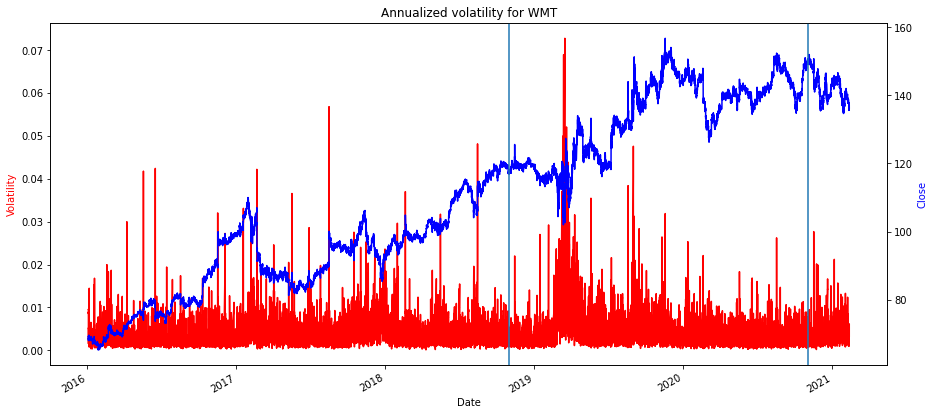

In [9]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [13]:
train = timeFilterAndBackfill(train_raw)
val = timeFilterAndBackfill(val_raw)
test = timeFilterAndBackfill(test_raw)

train = train[train.index.dayofweek <= 4].copy()
val = val[val.index.dayofweek <= 4].copy()
test = test[test.index.dayofweek <= 4].copy()

train["Open"] = np.where((train["Volume"] == 0), train["Close"], train["Open"])
train["High"] = np.where((train["Volume"] == 0), train["Close"], train["High"])
train["Low"] = np.where((train["Volume"] == 0), train["Close"], train["Low"])

val["Open"] = np.where((val["Volume"] == 0), val["Close"], val["Open"])
val["High"] = np.where((val["Volume"] == 0), val["Close"], val["High"])
val["Low"] = np.where((val["Volume"] == 0), val["Close"], val["Low"])

test["Open"] = np.where((test["Volume"] == 0), test["Close"], test["Open"])
test["High"] = np.where((test["Volume"] == 0), test["Close"], test["High"])
test["Low"] = np.where((test["Volume"] == 0), test["Close"], test["Low"])

def strided_axis0(a, L, overlap=1):
    if L==overlap:
        raise Exception("Overlap arg must be smaller than length of windows")
    S = L - overlap
    nd0 = ((len(a)-L)//S)+1
    if nd0*S-S!=len(a)-L:
        warnings.warn("Not all elements were covered")
    m,n = a.shape
    s0,s1 = a.strides
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(S*s0,s0,s1))

def blockshaped(arr, nrows, ncols, overlapping_5min_intervals = 12):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

    return np.flip(np.rot90((strided_axis0(arr, 24, overlap=overlapping_5min_intervals).reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)

train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()

X_train_pre_final = blockshaped(train_array, 24, 5, overlapping_5min_intervals = 12)
X_val_pre_final = blockshaped(val_array, 24, 5, overlapping_5min_intervals = 12)
X_test_pre_final = blockshaped(test_array, 24, 5, overlapping_5min_intervals = 12)

In [14]:
# create target from OHLC and Volume Data
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  returns = np.log(target_close_df['Close']/(target_close_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)
  
  targets = [2] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph * volatility)), 
           1, targets)
  
  targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph * volatility)), 
           0, targets)

  return targets

In [ ]:
volity_val = 5
alph = .15
y_train_pre_final = buildTargets(X_train_pre_final, alph=alph,  volity_int = volity_val)
y_val_pre_final = buildTargets(X_val_pre_final, alph=alph, volity_int = volity_val)
y_test_pre_final = buildTargets(X_test_pre_final, alph=alph, volity_int = volity_val)

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

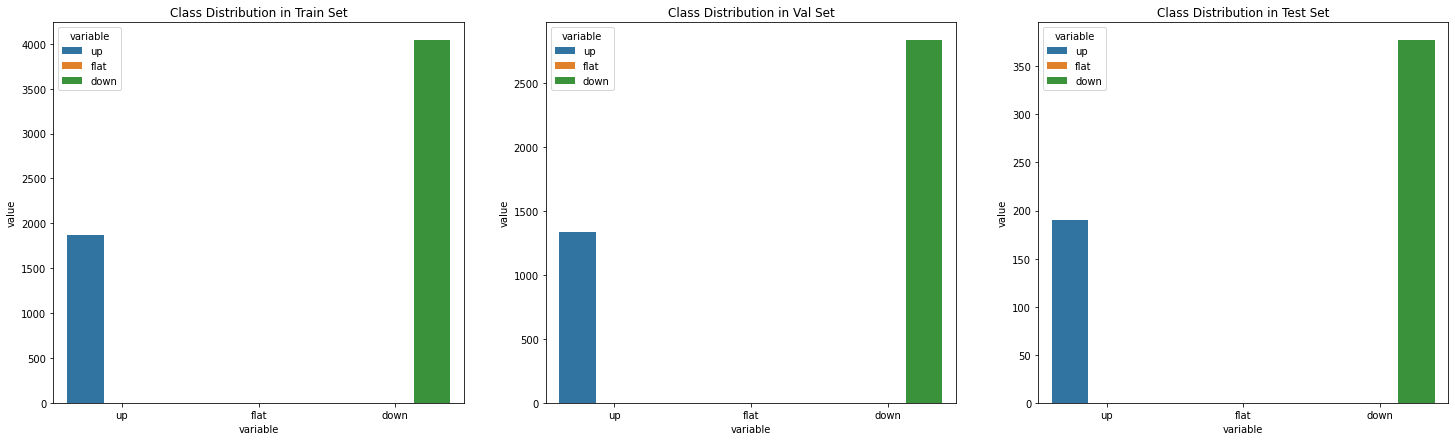

In [ ]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [ ]:
def createFinalData_RemoveLateAfternoonData(arr, labels):

  assert arr.shape[0] == len(labels), "X data do not match length of y labels"

  step_count = 0
  filtered_y_labels = []

  for i in range(arr.shape[0]):

    if i == 0:
      final_arr = arr[i]
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1

    elif i == 1:

      final_arr = np.stack((final_arr, arr[i]))
      filtered_y_labels.append(labels[i])
      step_count += 1

    elif step_count == 0: 
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
    
    elif (step_count) % 5 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 6 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 7 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count = 0
    
    else:
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
  
  return final_arr, filtered_y_labels

X_train, y_train = createFinalData_RemoveLateAfternoonData(X_train_pre_final, y_train_pre_final)
X_val, y_val = createFinalData_RemoveLateAfternoonData(X_val_pre_final, y_val_pre_final)
X_test, y_test = createFinalData_RemoveLateAfternoonData(X_test_pre_final, y_test_pre_final)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [ ]:
######
# Code fro scaling at a later date
######

# from sklearn.preprocessing import MinMaxScaler

# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = MinMaxScaler()
#     X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

# for i in range(X_val.shape[1]):
#     X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

# for i in range(X_test.shape[1]):
#     X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    

In [ ]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "flat": 0,
        "down": 0,
    }
    
    for i in obj:
        if i == 1: 
            count_dict['up'] += 1
        elif i == 0: 
            count_dict['down'] += 1
        elif i == 2: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

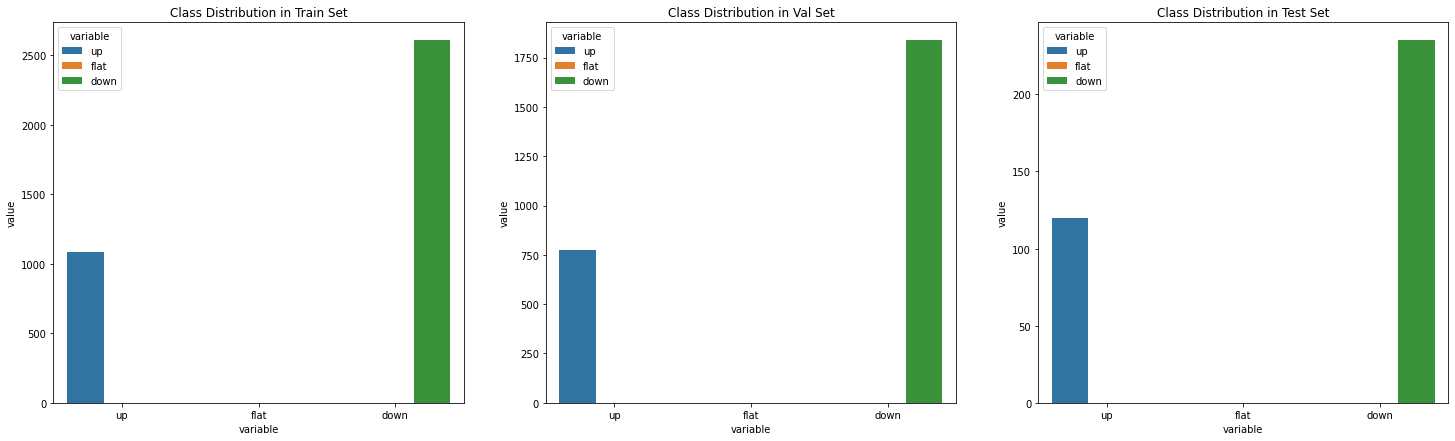

In [ ]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [ ]:
###### ONLY EXECUTE FOR 2D CNN #####

X_train = X_train.reshape(X_train.shape[0], 1,
                          X_train.shape[1], 
                          X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], 1,
                          X_val.shape[1], 
                          X_val.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1,
                          X_test.shape[1], 
                          X_test.shape[2])

In [ ]:
print(f'X Train Length {X_train.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test.shape}, y Test Label Length {y_test.shape}')

X Train Length (3690, 1, 5, 24), y Train Label Length (3690,)
X Val Length (2610, 1, 5, 24), y Val Label Length (2610,)
X Test Length (355, 1, 5, 24), y Test Label Length (355,)


# 2D CNN Build Model

In [ ]:
trainset = TensorDataset(torch.from_numpy(X_train).float(), 
                         torch.from_numpy(y_train).long())
valset = TensorDataset(torch.from_numpy(X_val).float(), 
                        torch.from_numpy(y_val).long())
testset = TensorDataset(torch.from_numpy(X_test).float(), 
                        torch.from_numpy(y_test).long())

In [ ]:
batch_size = 12

# train_data = []
# for i in range(len(X_train)):
#    train_data.append([X_train[i].astype('float'), y_train[i]])

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
i1, l1 = next(iter(train_loader))
print(i1.shape)

# val_data = []
# for i in range(len(X_val)):
#    val_data.append([X_val[i].astype('float'), y_val[i]])

val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
i1, l1 = next(iter(val_loader))
print(i1.shape)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
i1, l1 = next(iter(test_loader))
print(i1.shape)

torch.Size([12, 1, 5, 24])
torch.Size([12, 1, 5, 24])
torch.Size([12, 1, 5, 24])


In [ ]:
# Get next batch of training images
windows, labels = iter(train_loader).next()
print(windows)
windows = windows.numpy()

# plot the windows in the batch, along with the corresponding labels
for idx in range(batch_size):
    print(labels[idx])

tensor([[[[6.9240e+01, 6.8820e+01, 6.8310e+01,  ..., 6.8510e+01,
           6.8529e+01, 6.8440e+01],
          [6.9240e+01, 6.8840e+01, 6.8410e+01,  ..., 6.8520e+01,
           6.8550e+01, 6.8450e+01],
          [6.8591e+01, 6.8290e+01, 6.8130e+01,  ..., 6.8480e+01,
           6.8440e+01, 6.8380e+01],
          [6.8860e+01, 6.8300e+01, 6.8400e+01,  ..., 6.8520e+01,
           6.8440e+01, 6.8385e+01],
          [4.2199e+05, 2.9660e+05, 2.1491e+05,  ..., 7.6920e+04,
           1.1845e+05, 8.3425e+04]]],


        [[[6.8395e+01, 6.8440e+01, 6.8440e+01,  ..., 6.8500e+01,
           6.8490e+01, 6.8405e+01],
          [6.8470e+01, 6.8470e+01, 6.8560e+01,  ..., 6.8500e+01,
           6.8490e+01, 6.8430e+01],
          [6.8320e+01, 6.8410e+01, 6.8435e+01,  ..., 6.8480e+01,
           6.8350e+01, 6.8370e+01],
          [6.8440e+01, 6.8430e+01, 6.8541e+01,  ..., 6.8485e+01,
           6.8410e+01, 6.8370e+01],
          [1.7433e+05, 1.3218e+05, 1.3790e+05,  ..., 4.6596e+04,
           1.5244e+05,

In [ ]:
# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}
# Store size of training and validation sets
dataset_sizes = {'train':len(trainset),'val':len(valset)}
# Get class names associated with labels
classes = [0,1]

In [ ]:
class StockShiftClassification(nn.Module):
  def __init__(self):
    super(StockShiftClassification, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size = (1,4), stride=1, padding = 1)
    self.pool1 = nn.MaxPool2d(4,4)
    self.batchNorm1 = nn.BatchNorm2d(32)

    self.conv2 = nn.Conv2d(32, 64, kernel_size = (1,3), stride=1, padding = 1)
    self.pool2 = nn.MaxPool2d(3,3) 
    self.batchNorm2 = nn.BatchNorm2d(64) 

    self.conv3 = nn.Conv2d(64, 128, kernel_size = (1,2), stride=1, padding = 1)
    self.pool3 = nn.MaxPool2d(2,2)
    self.batchNorm3 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(128,1000) #calculate this
    self.fc2 = nn.Linear(1000, 500)
    self.fc3 = nn.Linear(500, 2)

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):

    x = F.relu(self.dropout(self.conv1(x)))
    x = self.pool1(x)
    x = self.batchNorm1(x)
    x = F.relu(self.dropout(self.conv2(x)))
    x = self.pool2(x)
    #x = self.batchNorm2(x)
    x = F.relu(self.dropout(self.conv3(x)))
    x = self.pool3(x)
    #x = self.batchNorm3(x)

    x = x.view(x.size(0), -1)

    # Linear layer
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    #x = self.fc4(x)

    output = x # F.softmax(x)

    return output


In [ ]:
# Instantiate the model
net = StockShiftClassification().float()

# Display a summary of the layers of the model and output shape after each layer
summary(net,(windows.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [12, 32, 7, 23]             160
           Dropout-2            [12, 32, 7, 23]               0
         MaxPool2d-3             [12, 32, 1, 5]               0
       BatchNorm2d-4             [12, 32, 1, 5]              64
            Conv2d-5             [12, 64, 3, 5]           6,208
           Dropout-6             [12, 64, 3, 5]               0
         MaxPool2d-7             [12, 64, 1, 1]               0
            Conv2d-8            [12, 128, 3, 2]          16,512
           Dropout-9            [12, 128, 3, 2]               0
        MaxPool2d-10            [12, 128, 1, 1]               0
           Linear-11                 [12, 1000]         129,000
           Linear-12                  [12, 500]         500,500
           Linear-13                    [12, 2]           1,002
Total params: 653,446
Trainable params:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)

criterion = nn.CrossEntropyLoss() 
# weights = torch.tensor([y_down_weight, y_up_weight, 1.]).to(device)
# criterion_weighted = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.00001)
# enumerate epochs
for epoch in range(10):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_loader):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(inputs.to(device))
        print(yhat)
        # calculate loss
        loss = criterion(yhat, targets.to(device))
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()

In [ ]:
def test_model(model,val_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in val_loader:
 
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)

            #print(f'Logits: {logits}')

            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits, dim=-2)
            # print(f'Probs after LogSoft: {probs}')

            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(2):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)

    
    return test_acc, recall_vals

In [ ]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(model,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.521
For class 0, recall is 0.5148936170212766
For class 1, recall is 0.5333333333333333


In [ ]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    history = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []

    start_time_sec = time.time()

    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss       = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 10 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history

In [ ]:
y_flat_num = y_train[np.where(y_train == 2)].size
y_down_weight = round((y_flat_num / y_train[np.where(y_train == 0)].size) * 1.2, 3) 
y_up_weight = round((y_flat_num / y_train[np.where(y_train == 1)].size) * 1.5, 3)

print(y_down_weight, y_up_weight, 1)

0.0 0.0 1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)

criterion = nn.CrossEntropyLoss() 
# weights = torch.tensor([y_down_weight, y_up_weight, 1.]).to(device)
# criterion_weighted = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001, weight_decay=0.00001)
epochs = 20

history = train(
    model = model,
    optimizer = optimizer,
    loss_fn = criterion,
    train_dl = train_loader,
    val_dl = test_loader,
    epochs=epochs,
    device=device)

train() called: model=StockShiftClassification, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch   1/ 20, train loss:  1.02, train acc:  0.68, val loss:  0.64, val acc:  0.66
Epoch  10/ 20, train loss:  0.61, train acc:  0.71, val loss:  0.65, val acc:  0.66
Epoch  20/ 20, train loss:  0.61, train acc:  0.71, val loss:  0.64, val acc:  0.66

Time total:     26.97 sec
Time per epoch:  1.35 sec


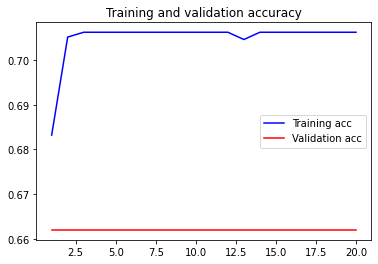

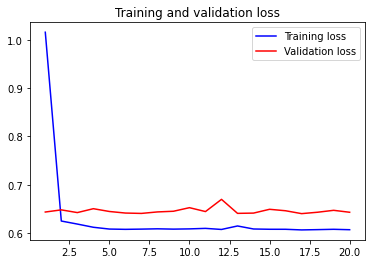

In [ ]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
def test_model(model,val_loader,device):
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []

        # Calculate the predictions on the test set and add to list
        for data in val_loader:
 
            inputs, labels = data[0].to(device), data[1].to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)

            #print(f'Logits: {logits}')

            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits)
            # print(f'Probs after LogSoft: {probs}')

            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)

        # Calculate the accuracy
        test_preds = np.array(test_preds)
        y_true = np.array(y_true)
        test_acc = np.sum(test_preds == y_true)/y_true.shape[0]
        
        # Recall for each class
        recall_vals = []
        for i in range(2):
            class_idx = np.argwhere(y_true==i)
            total = len(class_idx)
            correct = np.sum(test_preds[class_idx]==i)
            recall = correct / total
            recall_vals.append(recall)

    
    return test_acc, recall_vals
  

In [ ]:
# Calculate the test set accuracy and recall for each class
acc,recall_vals = test_model(model,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

Test set accuracy is 0.662
For class 1, recall is 1.0
For class 0, recall is 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


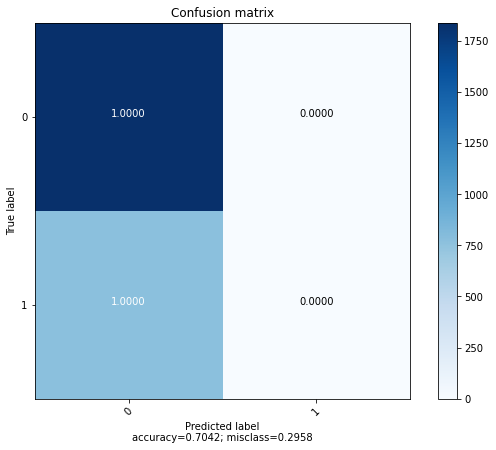

              precision    recall  f1-score   support

        down     0.7042    1.0000    0.8264      1838
          up     0.0000    0.0000    0.0000       772

    accuracy                         0.7042      2610
   macro avg     0.3521    0.5000    0.4132      2610
weighted avg     0.4959    0.7042    0.5820      2610



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        # print(inputs)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model.forward(inputs)
        #print(outputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
plot_confusion_matrix(conf_mat, [0,1])

from sklearn.metrics import precision_score

precision_score(lbllist.numpy(), predlist.numpy(), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(lbllist.numpy(), predlist.numpy(), target_names=["down","up"], digits=4))